Inferindo Comportamento de usuários
======
`Vamos supor que temos dados da quantidade de compras de um determinado produto. Nós estamos interessados em saber se o comportamento do usuário mudou ao longo do tempo. `

___

Nesse notebook iremos utilizar dados simbólicos e códigos do livro bayesian modeling for hackers. Na versão do livro, os dados representam o comportamento de um usuário com relação a quantidade de mensagem de textos que envia. Apesar disso, podemos utilizar os conceitos aqui apresentados em qualquer tipo de modelagem onde os dados são contagens de eventos.


<br>

Vamos supor que os dados abaixo representam o comportamento de compras de um determinado cliente ao longo do tempo. No eixo y temos a quantidade compras e no eixo x os tempo ( dias ). Olhando para o gráfico abaixo, você seria capaz de dizer se houve alguma mudança de comportamento desse cliente? 




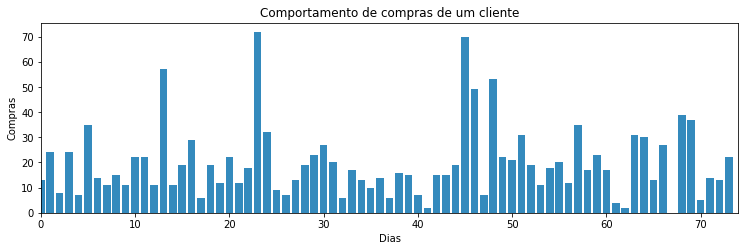

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Dias")
plt.ylabel("Compras")
plt.title("Comportamento de compras de um cliente")
plt.xlim(0, n_count_data);

## A modelagem

Vamos inicar nossa modelagem. Primeiramente, vamos lembrar que como vimos no notebook anterior -  [link do notebook](https://github.com/jmcabreira/Bayesian-Modeling/blob/main/Distribuicoes/Distribuicoes%20-%20Random%20Variables.ipynb) -
variáveis aleatórias de Poisson são apropriadas para modelar esse tipo de dados onde temos contagens de eventos. Denotando dia $i$'s e contagem de compras por $C_i$,


$$ C_i \sim \text{Poisson}(\lambda)  $$

Lembre-se que não sabemos o valor do parâmetro  $\lambda$. Quando olhamos para o gráfico acima, podemos notar, aparentemente, os valores de compras possuem uma tendencia a aumentar em algum ponto porém não sabemos onde e se esse aumento de fato ocorre. Dizer que é possível que haja essa tendência é o mesmo que dizer que o valor de  $\lambda$ aumenta em algum ponto do nosso range de observação. É importante salientar um valor maior de $\lambda$ atribui maior probabilidade a valores de compras maiores. Ou seja, nesse caso existe uma maior probabilidade de muitas compras terem sido feitas em um determinado dia.

Agora vamos representar essas observações matematicamente. Diante do que acabamos de discutir, vamos assumir que em um determinado período de observação desconhecido ( $\tau$ ), o parâmetro $\lambda$ variou para um valor maior. Dessa forma, teremos dois parâmetros $\lambda$ : um para o período menor que $\tau$ e outro para o resto das observações. Podemos também chamar $\tau$ de *switchpoint*:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$


Talvez vc deva estar se perguntando : ué, e se não houver essa mudança que estamos supondo? Bom, nesse caso $\lambda_1 = \lambda_2$ o que implica que a distribuição posteriori dos $\lambda$s serão similares. 


Estamos interessados em inferir os $\lambda$s desconhecidos. Para modelar sob a perspectiva bayesiana, nós temos que atribuir probabilidades a priori ( prior probabilities ) para diferentes possíveis valores de $\lambda$. Lembre-se de que $\lambda$s pode ser qualquer valor positivo, e que a distribuição *exponencial* fornece uma função de densidade contínua para números positivos. Dessa forma, a *exponencial* parece ser uma boa escolha para modelar $\lambda$. Além disso, lembre-se que a distribuição exponencial carrega consigo um parâmetro próprio e nós temos que incluí-lo na nossa modelagem. Vamos chamar esse parâmetro de $\alpha$.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}




$\alpha$ é um parâmetro que influencia em outro parâmetro e por isso é chamado de hiperparâmetro. Vamos assumir que o parâmetro $\alpha$ não possui grande influência na modelagem para termos um pouco mais de flexibilidade. Uma regra prática ( rule of thumb ) que podemos utilizar é definir o parâmetro exponencial igual ao inverso da média dos dados da observação. Como estamos modelando $\lambda$ utilizando a distribuição exponencial, podemos utilizar o seu esperado ( expected value ) :


$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 


Poderíamos também determinar duas distribuições a priori para $\lambda_i$ e consequentemente, determinar duas distribuições exponenciais com diferentes valores de $\alpha$. 

Com relação ao parâmetro $\tau$ (*switchpoint*), fica difícil apenas observando o plot em qual momento essa possível mudança ocorreu ( se é que ocorreu ). Por conta disso, vamos assumir uma distribuição de probabilidade uniforme para todos os possíveis dias como a priori. Em outras palavras : 

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}

Após todas essas premissas ( que assumimos ) estaremos interessados em descrobrir a distribuição de probabilidade posteriori que descreve o comportamento do nosso cliente. Para isso, iremos utilizar PyMC3. Uma biblioteca python para performar Análise Bayesiana que irá nos ajudar em simplicar toda essa matemática que vimos e que iremos enfrentar nas nossas modelagens.


Lembre-se, que em nossa modelagem estaremos representando os componentes ($\tau, \lambda_1, \lambda_2$ ) como variáveis.

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import pymc3 as pm

with pm.Model() as model:
    alpha =  1.0 / count_data.mean()  # count_data - > dados com compras do nosso cliente
    
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    
    tau = pm.DiscreteUniform('tau', lower = 0 , upper = n_count_data - 1)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


No código acima nós utilizamos PyMC3 para criar variáveis aleatórias que correspondem a $\lambda_1$ e $\lambda_2$. Essas variáveis são aleatórias no PyMC3 devido ao processo gerador das mesmas, que é aleatório.

In [4]:
with model:
    idx = np.arange(n_count_data) # index
    lambda_ = pm.math.switch(tau > idx , lambda_1, lambda_2)

Já no código acima, nós criamos uma função `lambda_` cujo pode ser pensada como uma variável aleatória. A função `switch()` atribui `lambda_1` ou `lambda_2` como valores para  `lambda_`, dependendo de qual lado do  `tau` estamos observando ( lembre-se que  `tau` é nosso switchpoint e que estamos considerando `lambda_`s diferentes ). 

Observe ainda que  `lambda_1`, `lambda_2` e `tau` são aleatórios, e por consequência,  `lambda_`  também o será. 



In [5]:
with model:
    observation = pm.Poisson("obs", lambda_, observed = count_data)

A variável `observation` combina nossos dados `count_data` com nosso esquema de geração de dados que foi proposto, dado pela nossa variável `lambda_` e pela chave `observed` da Poisson.

O código abaixo será melhor explicado nos próximos notebooks, logo, a princípio não vamos dar muitos detalhes a respeito. Apesar disso, podemos entender essa etapa como um processo de aprendizagem. O que estamos utilizando aqui é *Markov Chain Monte Carlo* (MCMC) que também será melhor detalhado posteriormente. Essa técnica nos da milhares de variáveis aleatórias das distribuições de probabilidades posteriori de $\lambda_1, \lambda_2$ e $\tau$. 

Iremos em seguida plotar as distribuições de provbabilidades dessas variáveis para observa-las. Abaixo, nós coletamos amostras ( conhecidas como *traces* na literatura de MCMC ) em histogramas.


In [6]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 581 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [7]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

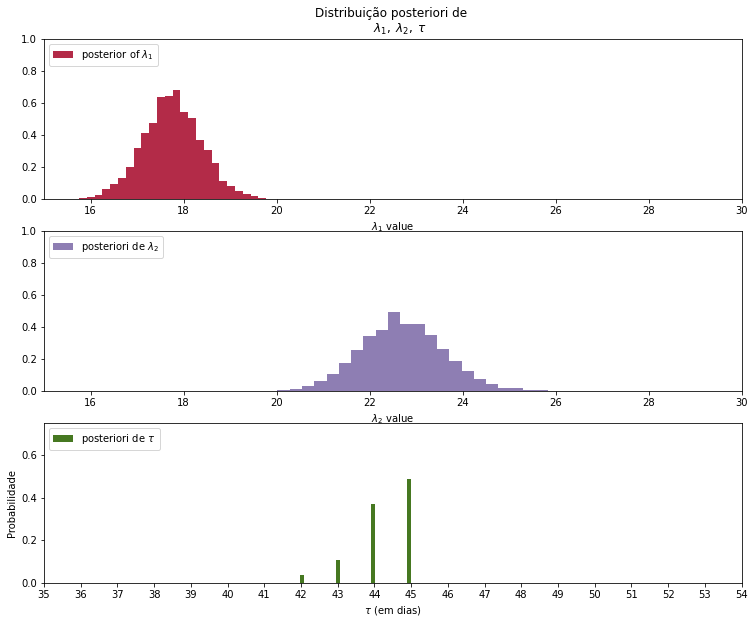

In [8]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Distribuição posteriori de 
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posteriori de $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posteriori de $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (em dias)")
plt.ylabel("Probabilidade");

## Como interpretamos os resultados ?


Primeiramente devemos lembrar que a metodologia bayesiana nos dá distribuições de probabilidades como resultado. Acima, temos as distribuições para os parâmetros $\lambda$s e $\tau$. Pontos que devemos observar:
* A incerteza da estimação:
    * Quando mais largo for a distribuição, maior a incerteza da inferência
* Podemos observar valores plausíveis para $\lambda$s
    * $\lambda_1$ em torno de 18 
    * $\lambda_2$ em torno de 23

* As distribuições a posteriori de $\lambda_1$ e $\lambda_2$ são distintas
    * Isso indica que é bem provável que, de fato, houve mudança de comportamento do cliente

* A distribuição de $\tau$ é uma distribuição discreta
    * Podemos notar que sua distribuição a posteriori
    * Não atribui probabilidades a intervalos
        * Temos, próximo do dia 45, 50% de chance do usuário ter mudado seu comportamento
    * Se não tivéssemos mudanças de comportamento ou se tivesse ocorrido de uma forma gratual ao longo do tempo, a distribuição 
    a posteriori seria mais larga
        * Isso indicaria que teríamos muitos dias como candidados para $\tau$
    * A posteriori apresentada para $\tau$ temos apenas três ou quatro dias que seriam candidatos a serem escolhidos como
    o switchpoint da mudança de comportamento

Importante nota que as distribuições de probabilidades a posteriori dos $\lambda$s não se parecem com distribuições exponenciais apesar de termos utilizado variáveis aleatórias com essa característica em nosso a priori. Isso não implica nenhum problema em nossa modelage, pois estamos utilizando os recursos computacionais para fazer com que o algorítmo bayesiano nos dê a distribuição a priori que mais representa os dados, dado nossa modelagem e as observações.

<br>




Vamos utilizar amostras da nossas distribuições a posteriori para responder a pergunta: Qual o valor esperado de comprar para esse cliente no dia $t, 0 \le t \le 70$ ? Lembre-se de que o valor experado de uma variável aleatória de Poisson é igual ao seu parâmetro $\lambda$. Dessa forma, essa pergunta é o mesmo que perguntar *Qual é o valor esperado de $\lambda$ no dia $t$* ?

No código abaixo, considere $i$ sendo o index da distribuição a posteriori. Dado o dia $t$, nós retiramos a média sobre todos os valores possívels de $\lambda_i$ para o dia $t$ utilizando  $\lambda_i = \lambda_{1,i}$, se $t \lt \tau_i$ ( ou seja, se a mudança de comportamente do cliente ainda não ocorreu ), caso contrário  $\lambda_i = \lambda_{2,i}$





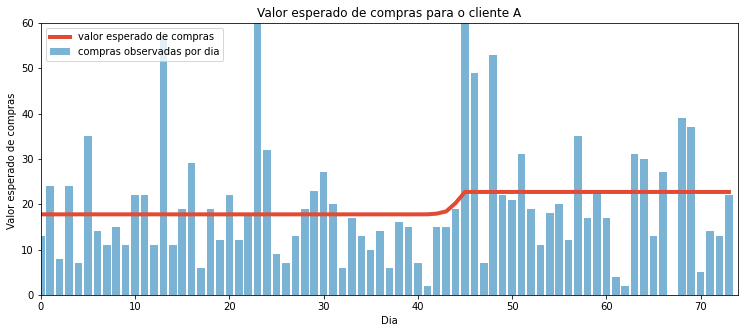

In [11]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contem
# N amostras da distribuição a posteriori
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix é o index de todas as amostras de tau correspondentes ao
    # the switchpoint que ocorreram anteriormente ao dia (day)
    ix = day < tau_samples
    # cada amostra a posteriori corresponde a valor para  tau.
    # para cada dia, o valor correspondente de tau indica se estamos na regiao do lamba_1 ou lambda_2
    # Quando retiramos a amostra a posteiori de lambda1/2, estamos tirando a média
    # de todas as amostras para termos o valor esperado de lambda naquele dia em questão
    # o count é uma variável aleatória de Poisson e por conta disso, 
    # lambda do parâmetro de Poisson é o valor esperado da contagem.

    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="valor esperado de compras")
plt.xlim(0, n_count_data)
plt.xlabel("Dia")
plt.ylabel("Valor esperado de compras ")
plt.title("Valor esperado de compras para o cliente A")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="compras observadas por dia")

plt.legend(loc="upper left");

Nossa análise mostra que temos fortes indícios de que houve mudança no comportamento do cliente. Se essa mudança não tivesse ocorrido, os valores de $\lambda_1$ seria próximo de $\lambda_2$. Ainda, podemos notar através do gráfico que essa mudança foi abrupta, dado o pico que temos no valor esperado de mensagems, como demonstrado também no pico que temos na distribuição a posteriori de  $\tau$. Poderíamos investigar o motivo dessa mudança de comportamento. Será que houve algum efeito externo ou foi algo que ocorreu aqui dentro da nossa casa ( na empresa ).

---